# Learning the Gaussian Curve

In the notebook implementing the basic back propagation algorithm from scratch, I used as an example case of learning a gaussian curve. In theory, our model should be able to learn this well since there is no noise in the model (we are learning a deterministic function).

I will explore more robust approaches in deep learning to properly learn this gaussian curve. Some ideas I will try:

- Use more data
- Hyper-Parameter Testing
  - Number and Shape of Layers in the Network
  - Learning Rate
- Better Training Procedure: will use the Adam Algorithm instead of SGD


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

from random import random
from time import time

## Defining a Gaussian Curve

In [2]:
def create_gaussian_curve(mean, variance, delta=0.2):
    std = math.sqrt(variance)
    normalize = 1 / (std * math.sqrt(2 * 3.14159))

    def gaussian_curve(x, y):
        term = (x - mean) / std
        expected = normalize * np.exp(-1/2 * term * term)
        return 1 if abs(expected - y) <= delta else 0
    
    return gaussian_curve


In [3]:
num_points = 1000000

In [4]:
gauss_func = create_gaussian_curve(0.0, 0.05)
points = np.random.rand(2, num_points) * 4 - 2
labels = np.apply_along_axis(lambda x: gauss_func(x[0], x[1]), axis=0, arr=points)

random_assignment = np.random.rand(num_points)
train_mask = random_assignment <= 0.8
valid_mask = (random_assignment > 0.8) & (random_assignment <= 0.9)
test_mask = random_assignment > 0.9

train_data = points[:, train_mask]
train_labels = labels[train_mask]

valid_data = points[:, valid_mask]
valid_labels = labels[valid_mask]

test_data = points[:, test_mask]
test_labels = labels[test_mask]

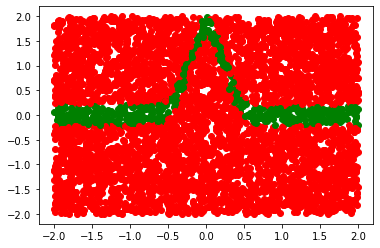

In [5]:
# Let's make a plot to see where the curve is being drawn.
# We will look at the first 5,000 points.

for i in range(5000):
    point = train_data[:, i]
    label = train_labels[i]
    plt.plot(point[0], point[1], 'go' if label == 1 else 'ro')

plt.show()

## Defining the Model

### Activation Functions

In [6]:
def relu(X):
    mask = X >= 0
    return X * mask


In [7]:
def relu_deriv(X):
    return (X >= 0).astype(float)


In [8]:
def sigmoid(X):
    return 1. / (1 + np.exp(-X))


In [9]:
def sigmoid_deriv(X):
    sig = sigmoid(X)
    return sig * (1 - sig)


### Loss Functions

In [10]:
def binary_cross_entropy_loss(output, expected):
    m = output.shape[1]

    # Offset the output if there are any values exactly equal to
    # zero or one to avoid log(0).
    zero_correct = (output == 0).astype(float) * 1e-10 
    one_correct = (output == 1).astype(float) * (-1e-10)
    output = output + zero_correct + one_correct

    return np.sum((expected * -np.log(output)) + (1 - expected) * -np.log(1 - output)) / m


In [11]:
def binary_cross_entropy_loss_grad(output, expected):

    m = output.shape[1]
    
    # Want to avoid divide by 0.
    epsilon = 1e-10
    zero_correct = (output == 0.0).astype(float) * epsilon
    one_correct = (output == 1.0).astype(float) * -epsilon
    output = output + zero_correct + one_correct
    
    return (1. / m) * ((expected / output) - (1 - expected) / (1 - output))


### Random Initialization

In [12]:
# Note: When initializing the layers, we will assume that the output
# layer is always a single output through a sigmoid activation.
def xavier_initialization(input_size, layer_sizes):
    layers = []
    
    prev_layer_size = input_size

    for size in layer_sizes:
        normalize = 1. / math.sqrt(prev_layer_size)
        weights = np.random.randn(size, prev_layer_size) * normalize
        biases = np.random.randn(size, 1) * normalize
        layers.append((weights, biases))

        prev_layer_size = size
        
    # Add a final output layer for sigmoid activation.
    weights = np.random.randn(1, prev_layer_size)
    biases = np.random.randn(1, 1)
    layers.append((weights, biases))
    
    return layers


### Model Functions

In [13]:
def forward(model, X):
    Y = X

    linear_outputs = []
    outputs = []

    for (i, (weights, biases)) in enumerate(model['layers'][0:-1]):
        Y = np.dot(weights, Y) + biases
        linear_outputs.append(Y)

        Y = relu(Y)
        outputs.append(Y)
        

    # Note: Last layer is processed by sigmoid activation.
    weights, biases = model['layers'][-1]

    Y = np.dot(weights, Y) + biases
    linear_outputs.append(Y)

    Y = sigmoid(Y)
    outputs.append(Y)

    # Save the results of the forward pass so we can do a backward
    # pass on them later.
    if 'no_grad_check' not in model or not model['no_grad_check']:
        model['linear_outputs'] = linear_outputs
        model['input'] = X
        model['outputs'] = outputs
        model['result'] = Y

    return Y
 

In [47]:
def backward(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass.

    layers = model['layers']
    linear_outputs = model['linear_outputs']
    outputs = model['outputs']
    X = model['input']
    result = model['result']

    L = len(layers)
    m = result.shape[1] # Number of samples.

    # Note: We can have multiple samples in the outputs, so we
    # will end up with a gradient per sample.
    output_prev_layer = X if len(outputs) <= 1 else outputs[-2]
    loss_grad = binary_cross_entropy_loss_grad(result, expected)
    error_last_layer = loss_grad * sigmoid_deriv(linear_outputs[-1])
    bias_grad_last_layer = np.sum(error_last_layer, axis=1).reshape(-1, 1) / m
    weights_grad_last_layer = np.dot(error_last_layer, output_prev_layer.T) / m # outer product
    grad_last_layer = (weights_grad_last_layer, bias_grad_last_layer)

    errors = [error_last_layer]
    grads = [grad_last_layer]

    # Enumerate layers in reverse order to compute errors
    # and gradients.
    for i in range(L - 2, -1, -1):
        linear_output = linear_outputs[i]
        output_prev_layer = X if i == 0 else outputs[i-1]
        error_next_layer = errors[-1]
        weights_next_layer, bias_next_layer = layers[i+1]

        error = np.dot(weights_next_layer.T, error_next_layer) * sigmoid_deriv(linear_output)
        bias_grad = np.sum(error, axis=1).reshape(-1, 1) / m
        weights_grad = np.dot(error, output_prev_layer.T) / m
        
        errors.append(error)
        grads.append((weights_grad, bias_grad))
        
    # Reverse the order of errors and gradients so they go from
    # first layer to last.
    errors.reverse()
    grads.reverse()
    
    if 'no_grad_check' not in model or not model['no_grad_check']:
        model['errors'] = errors
        model['grads'] = grads
    
    return grads, errors


In [48]:
def gradient_clipping(model, threshold=1.0):
    """
    Returns True if the gradient was clipped, False otherwise.
    """
    l2_norm = 0

    for grad in model['grads']:
        grad_weight, grad_bias = grad
        l2_norm += np.sum(grad_weight * grad_weight)
        l2_norm += np.sum(grad_bias * grad_bias)
        
    l2_norm = math.sqrt(l2_norm)

    if l2_norm <= threshold:
        return False

    for (i, grad) in enumerate(model['grads']):
        grad_weight, grad_bias = grad

        grad_weight = grad_weight * threshold / l2_norm
        grad_bias = grad_bias * threshold / l2_norm

        model['grads'][i] = (grad_weight, grad_bias)
        
    return True
    
    

In [49]:
def no_grad_check(model):
    model['no_grad_check'] = True


In [50]:
def grad_check(model):
    model['no_grad_check'] = False


### Gradient Update

In [51]:
def step_SGD(model, lr=0.1):
    # Note: We are assuming the model has already gone
    # through back propagation and all the gradients have
    # been calculated.
    
    new_layers = []

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]
        
        weight = weight + (lr * grad_weight)
        bias = bias + (lr * grad_bias)

        model['layers'][i] = (weight, bias)


In [52]:
def reset_Adam(model):
    # We keep track of exponential moving averages of our
    # Adam optimization algorithm, cached in the model.
    # If we are starting to train from scratch, we need
    # to know to set these averages to 0.
    mt = []
    vt = []

    for (i, layers) in enumerate(model['layers']):
        weight, bias = layers
        mt.append((np.zeros_like(weight), np.zeros_like(bias)))
        vt.append((np.zeros_like(weight), np.zeros_like(bias)))
        
    model['mt'] = mt
    model['vt'] = vt
    model['t'] = 0


In [53]:
def step_Adam(model, lr, beta_1=0.9, beta_2=0.999, epsilon=1e-30):
    # Note: We are assuming the model has already gone through
    # back propagation and all the gradients have been calculated.
    
    t = model['t'] + 1

    one_minus_beta_1 = 1 - beta_1
    one_minus_beta_2 = 1 - beta_2

    one_minus_beta_1t = 1 - math.pow(beta_1, t)
    one_minus_beta_2t = 1 - math.pow(beta_2, t)

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]

        mt_minus_1_weight, mt_minus_1_bias = model['mt'][i]
        vt_minus_1_weight, vt_minus_1_bias = model['vt'][i]
        
        # Calculating exponentially moving averages.
        mt_weight = beta_1 * mt_minus_1_weight + one_minus_beta_1 * grad_weight
        mt_bias = beta_1 * mt_minus_1_bias + one_minus_beta_1 * grad_bias
        
        vt_weight = beta_2 * vt_minus_1_weight + one_minus_beta_2 * grad_weight * grad_weight
        vt_bias = beta_2 * vt_minus_1_bias + one_minus_beta_2 * grad_bias * grad_bias

        # Bias correction of our moving averages.
        mt_hat_weight = mt_weight / one_minus_beta_1t
        mt_hat_bias = mt_bias / one_minus_beta_1t
        vt_hat_weight = vt_weight / one_minus_beta_2t
        vt_hat_bias = vt_bias / one_minus_beta_2t

        # Calculate change in weights.
        deltat_weight = mt_hat_weight / (np.sqrt(vt_hat_weight) + epsilon)
        deltat_bias = mt_hat_bias / (np.sqrt(vt_hat_bias) + epsilon)
        
        # Update weights.
        weight = weight + (lr * deltat_weight)
        bias = bias + (lr * deltat_bias)

        # Write to model.
        model['layers'][i] = (weight, bias)
        model['mt'][i] = (mt_weight, mt_bias)
        model['vt'][i] = (vt_weight, vt_bias)

    
    model['t'] = t
        



## Defining Hyper Parameters

In [63]:
learning_rates = np.logspace(-3, -5, num=3)

layer_sizes_list = [
    [30, 15],
    [40, 16],
    [20, 8, 3],
    [35, 20, 4],
    [40, 20, 10],
    [50, 30, 8],
    [60, 40, 15, 4],
    [50, 30, 15, 8],
]

batch_sizes = [int(b) for b in np.logspace(3, 5, num=3)]


We currently have 54 unique combinations of hyper parameters, which is too much to test in a reasonable amount of time. We will randomly sample 10 of those 54 hyper parameter settings to try out.

In [64]:
# Note that it is possible we could end up testing the same hyper parameter settings
# multiple times. We won't correct for this.

hyperparams = []

for i in range(10):
    lr = learning_rates[int(math.floor(len(learning_rates) * random()))]
    layer_sizes = layer_sizes_list[int(math.floor(len(layer_sizes_list) * random()))]
    batch_size = batch_sizes[int(math.floor(len(batch_sizes) * random()))]

    hyperparams.append({'lr': lr, 'layer_sizes': layer_sizes, 'batch_size': batch_size})



## Creating and Training Model

In [65]:
def create_model(layer_sizes):
    model = { 'layers': xavier_initialization(2, layer_sizes) }
    return model


In [66]:
def train_model(model, train_data, train_labels, lr, batch_size, epochs=10000, logs=True):

    m = train_data.shape[1]

    train_errors = []
    grad_mags = []

    reset_Adam(model)

    for i in range(epochs):
        for (batch_i, batch_start) in enumerate(range(0, m, batch_size)):
            batch_X = train_data[:, batch_start:min(m, batch_start+batch_size)]
            batch_Y = train_labels[batch_start:min(m, batch_start+batch_size)]

            forward(model, batch_X)
            backward(model, batch_Y)
            gradient_clipping(model, threshold=1.0)
            step_Adam(model, lr=lr)
            # step_SGD(model, lr=lr)

        if i % 100 == 0:
            # Turn off gradient checking while we calculate training
            # and test loss.
            no_grad_check(model)

            train_output = forward(model, train_data)
            train_error = binary_cross_entropy_loss(train_output, train_labels)
            train_errors.append(train_error)
            
            grad_mag = 0
            max_grad = 0
            min_grad = float('inf')

            mean_grad = 0
            var_grad = 0
            n_grad = 0

            # Checking the overall squared gradient magnitude to look for
            # any issues with vanishing / exploding gradients.
            for grad in model['grads']:
                weight, bias = grad
                grad_mag += np.sum(weight * weight)
                grad_mag += np.sum(bias * bias)

                max_grad = max(max_grad, np.amax(np.abs(weight)))
                min_grad = min(min_grad, np.amin(np.abs(weight)))
                
                mean_grad += np.sum(weight)
                mean_grad += np.sum(bias)
                
                var_grad += np.sum(weight * weight)
                var_grad += np.sum(bias * bias)
                
                n_grad += np.prod(weight.shape)
                n_grad += np.prod(bias.shape)

            grad_mag = math.sqrt(grad_mag)
            mean_grad = mean_grad / n_grad
            var_grad = var_grad / n_grad
            
            grad_mags.append(grad_mag)
             
            if logs and i % 500 == 0:
                print(f'Epoch {i + 1}')
                print(f'Train Error {train_error}')
                print(f'Grad Mag={grad_mag}, Grad Min={min_grad}, Grad Max={max_grad}')
                print(f'Grad Mean={mean_grad}, Grad Var={var_grad}')                
                print('')

            # Turn gradient checking back on before we start a new epoch.
            grad_check(model)

    return train_errors, grad_mags


In [ ]:
models = []
valid_errors = []
train_error_logs = []
grad_mag_logs = []
train_times = []

data = train_data
labels = train_labels

# t_hyperparams = [
#     {
#         'batch_size': 1,
#         'lr': 0.001,
#         'layer_sizes': [50, 20, 8],
#     },
#     {
#         'batch_size': 10,
#         'lr': 0.001,
#         'layer_sizes': [50, 20, 8],
#     },
#     {
#         'batch_size': 100,
#         'lr': 0.001,
#         'layer_sizes': [50, 20, 8],
#     },
#     {
#         'batch_size': 1000,
#         'lr': 0.001,
#         'layer_sizes': [50, 20, 8],
#     },    
# ]

# For each set of hyper parameters, create and train a new model.
# Record the trained model with the corresponding validation error.
for (i, hyperparam) in enumerate(hyperparams):
    print(f'Training model {i + 1} / {len(hyperparams)}')
    print(f'lr={hyperparam["lr"]}, layer_sizes={hyperparam["layer_sizes"]}, batch_size={hyperparam["batch_size"]}')

    start_time = time()

    model = create_model(hyperparam['layer_sizes'])

    train_errors, grad_mags = train_model(model, data, labels, lr=hyperparam['lr'], batch_size=hyperparam['batch_size'])

    no_grad_check(model)

    train_error_logs.append(train_errors)
    grad_mag_logs.append(grad_mags)

    valid_output = forward(model, valid_data)
    valid_error = binary_cross_entropy_loss(valid_output, valid_labels)

    grad_check(model)
    
    models.append(model)
    valid_errors.append(valid_error)

    end_time = time()

    print(f'Model took {(end_time - start_time) / 60:0.2f}m to train.')
    print('\n')



Training model 1 / 10
lr=1e-05, layer_sizes=[20, 8, 3], batch_size=10000
Epoch 1
Train Error 1.0001606085505748
Grad Mag=0.009180508151377026, Grad Min=0.0, Grad Max=0.005965034904209821
Grad Mean=2.413279737568874e-05, Grad Var=3.254120846235522e-07



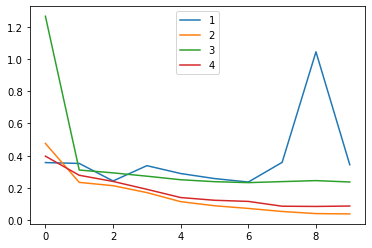

In [62]:
for (i, model) in enumerate(models):
    line = plt.plot(train_error_logs[i])

plt.legend([1, 2, 3, 4])

plt.show()

In [ ]:
plt.plot(grad_mags)